In [1]:
# Data and Stats packages
import numpy as np
import pandas as pd
import re
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn import metrics, datasets
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier


# Visualization packages
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams['figure.figsize'] = (13.0, 6.0)

# Other
import itertools

# Aesthetic settings
from IPython.display import display
pd.set_option('display.max_columns', 999)
pd.set_option('display.width', 500)
sns.set_style('whitegrid')
sns.set_context('talk')

#Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
#import data
df_07to11 = pd.read_csv('./data/LoanStats3a.csv',header=1)
df_2016Q1 = pd.read_csv('./data/LoanStats_2016Q1.csv',header=1)
df_2016Q2 = pd.read_csv('./data/LoanStats_2016Q2.csv',header=1)
df_2016Q3 = pd.read_csv('./data/LoanStats_2016Q3.csv',header=1)
df_2016Q4 = pd.read_csv('./data/LoanStats_2016Q4.csv',header=1)

In [3]:
#concat quarterly dfs for 2016
df_16 = pd.concat([df_2016Q1,df_2016Q2,df_2016Q3,df_2016Q4])

In [4]:
#figure out index when 2007 data begins
not07 = True
special = 0
i = 0
while(not07):
    val = df_07to11['issue_d'].values[i][-2:]  
    if val == '07':
        special = i
        not07 = False
    i+=1

In [5]:
#drop all data points before this (2008-2011 data)
df_07 = df_07to11.drop(np.arange(special))

In [6]:
#function to clean datasets
def clean(df):
    preds = ['loan_status'
         ,'loan_amnt'
         ,'funded_amnt'
         ,'term'
         ,'int_rate'
         ,'installment'
         ,'emp_length'
         ,'home_ownership'
         ,'annual_inc'
         ,'issue_d'
         ,'zip_code'
         ,'addr_state'
         ,'dti'
         ,'delinq_2yrs'
         ,'earliest_cr_line'
         ,'inq_last_6mths'
         ,'mths_since_last_delinq'
         ,'open_acc'
         ,'pub_rec'
         ,'revol_bal'
         ,'revol_util'
         ,'total_acc'
        ]

    states = df['addr_state'].unique().tolist()
    
    df = df[preds]

    df['term'] = df['term'].str.rstrip(' months').astype('float')
    df['int_rate'] = df['int_rate'].str.rstrip('%').astype('float') / 100.0
    df['emp_length'] = df['emp_length'].str.strip('< + years').astype('float')
    df['issue_d'] = pd.to_datetime(df['issue_d'])
    df['zip_code'] = df['zip_code'].str.replace('xx','00').astype('float')
    df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'])
    
    df['length_credit_history'] = (df['issue_d']-df['earliest_cr_line']).astype('timedelta64[D]')/30.44
    df['mths_since_last_delinq'] = np.where(df['mths_since_last_delinq'].isna() , df['length_credit_history'], df['mths_since_last_delinq'])
    df['revol_util'] = df['revol_util'].str.rstrip('%').astype('float') / 100.0
    df = pd.get_dummies(df, columns = ['home_ownership'] )
    df = pd.get_dummies(df, columns = ['addr_state'] )

    df['loan_status'] = np.where(df['loan_status'] == 'Fully Paid' , 'paid', df['loan_status'])
    df['loan_status'] = np.where(df['loan_status'] == 'Charged Off' , 'default', df['loan_status'])
    df['loan_status'] = np.where(df['loan_status'] == 'Does not meet the credit policy. Status:Fully Paid' , 'paid', df['loan_status'])
    df['loan_status'] = np.where(df['loan_status'] == 'Does not meet the credit policy. Status:Charged Off' , 'default', df['loan_status'])
    
    preds.append('length_credit_history')

    df = df.dropna()
    return df

In [7]:
#clean the dfs
df_07 = clean(df_07)
df_16 = clean(df_16)

In [8]:
paid07 = df_07[df_07['loan_status'] == 'paid']
default07 = df_07[df_07['loan_status'] == 'default']

In [9]:
paid16 = df_16[df_16['loan_status'] == 'paid']
default16 = df_16[df_16['loan_status'] == 'default']

In [10]:
print('paid ' + str(paid07.shape[0]))
print('default ' + str(default07.shape[0]))
print('total = ' + str(paid07.shape[0] + default07.shape[0]))

paid 2142
default 786
total = 2928


In [11]:
print('paid ' + str(paid16.shape[0]))
print('default ' + str(default16.shape[0]))
print('total = ' + str(paid16.shape[0] + default16.shape[0]))

paid 167651
default 55760
total = 223411


In [12]:
df2016 = pd.concat([paid16, default16])
df2007 = pd.concat([paid07, default07])

In [13]:
df2007['loan_status'] = np.where(df2007['loan_status'] == 'paid' , 1, 0)

In [14]:
df2016['loan_status'] = np.where(df2016['loan_status'] == 'paid' , 1, 0)

In [15]:
df_07 = pd.DataFrame(df2007)
df_16 = pd.DataFrame(df2016)

In [16]:
#Remove datetime columns and interest rates
cols_to_remove = ['int_rate', 'issue_d', 'earliest_cr_line', 'zip_code', 'term', 'funded_amnt']
df_07 = df_07.drop(cols_to_remove, axis = 1)
df_16 = df_16.drop(cols_to_remove, axis = 1)

In [17]:
# Normalize Data
to_norm = ['loan_amnt', 'installment', 'emp_length', 'annual_inc', 'dti', 'delinq_2yrs',
          'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
          'total_acc','length_credit_history']

In [18]:
from scipy.stats import zscore
def norm(df, cols):
    for e in cols:
        df[e] = zscore(df[e])
    return df

In [19]:
df_07 = norm(df_07, to_norm)
df_16 = norm(df_16, to_norm)

In [20]:
#Split data into train and test
df_07_train, df_07_test = train_test_split(df_07, test_size=0.2, random_state=90)
df_16_train, df_16_test = train_test_split(df_16, test_size=0.2, random_state=90)

#Split to x and y
df_07_X_train = df_07_train.drop(labels = 'loan_status', axis = 1)
df_07_y_train = df_07_train.loan_status
df_07_X_test = df_07_test.drop(labels = 'loan_status', axis = 1)
df_07_y_test = df_07_test.loan_status

df_16_X_train = df_16_train.drop(labels = 'loan_status', axis = 1)
df_16_y_train = df_16_train.loan_status
df_16_X_test = df_16_test.drop(labels = 'loan_status', axis = 1)
df_16_y_test = df_16_test.loan_status

*** Trivial Model ***

We implemented a trivial model that always predicts a given person will repay their loan. It is worth noting that this model is representative of Lending Club's prediction. Since we only have access to accepted loan data, Lending Club is inherently predicting that a loan will be repayed because they wouldn't give a loan that they expected not to be repayed.

In [21]:
#Trivial Model in which all loans are accepted
triv_mod_07_train = np.sum(df_07_y_train)/len(df_07_y_train)
triv_mod_07_test = np.sum(df_07_y_test)/len(df_07_y_test)
print('2007 Data\nTrain score: '+str(triv_mod_07_train))
print('Test score: '+str(triv_mod_07_test))
triv_mod_16_train = np.sum(df_16_y_train)/len(df_16_y_train)
triv_mod_16_test = np.sum(df_16_y_test)/len(df_16_y_test)
print('2016 Data\nTrain score: '+str(triv_mod_16_train))
print('Test score: '+str(triv_mod_16_test))

2007 Data
Train score: 0.7297181895815542
Test score: 0.7389078498293515
2016 Data
Train score: 0.7504867731972606
Test score: 0.750128684287089


*** Logistic Regression Model ***

The first model we chose is a simple logistic regression with cross validation. We trained it on the training set and printed the scores on both the training and test data sets. The test accuracy was 0.737 which is just below our trivial model's score- meaning it performs moderately worse than Lending Club's algorithm.

In [22]:
#Logistic regression on 2007 data
log_mod07 = LogisticRegressionCV().fit(df_07_X_train, df_07_y_train.values)

log_mod07_train_score = log_mod07.score(df_07_X_train,df_07_y_train.values)
log_mod07_test_score =log_mod07.score(df_07_X_test,df_07_y_test.values)
print("The accuracy of Logistic Regression Model on 2007 Training Set is ", log_mod07_train_score)
print("The accuracy of Logistic Regression Model on 2007 Testing Set is ", log_mod07_test_score)

The accuracy of Logistic Regression Model on 2007 Training Set is  0.7292912040990607
The accuracy of Logistic Regression Model on 2007 Testing Set is  0.7372013651877133


In [23]:
#Logistic regression on 2016 data
log_mod16 = LogisticRegressionCV().fit(df_16_X_train, df_16_y_train.values)

log_mod16_train_score = log_mod16.score(df_16_X_train, df_16_y_train.values)
log_mod16_test_score = log_mod16.score(df_16_X_test, df_16_y_test.values)
print("The accuracy of Logistic Regression Model on 2016 Training Set is ", log_mod16_train_score)
print("The accuracy of Logistic Regression Model on 2016 Testing Set is ", log_mod16_test_score)

The accuracy of Logistic Regression Model on 2016 Training Set is  0.7518407859988362
The accuracy of Logistic Regression Model on 2016 Testing Set is  0.7517400353602041


*** Decision Tree Model ***

To create a Decision Tree model, we began by optimizing the tree depth. Our optimal depth was found to be max_depth =i. Depths past i appeared to be overfit, yielding great train accuracies, and poor test accuracies. We then ran the model on both 2007 and 2016 data. The model yielded comparable accuracies to that of Lending Club's.

In [24]:
# Get train score, cross val score means and stds
train_scores = []
cvmeans = []
cvstds = []
depths = list(range(1, 15))
#for all specified maximum tree depths --> fit model and add scores to list
for i in depths:
    #create/fit model
    tree = DecisionTreeClassifier(max_depth = i).fit(df_07_X_train, df_07_y_train.values) 
    train_scores.append(tree.score(df_07_X_train, df_07_y_train.values))
    score = cross_val_score(estimator=tree, X=df_07_X_train, y=df_07_y_train.values, cv=5)
    cvmeans.append(score.mean())
    cvstds.append(score.std())
    
cvstds = np.array(cvstds)
cvmeans = np.array(cvmeans)

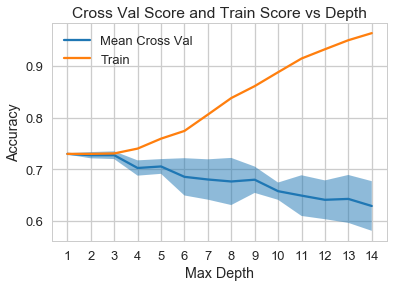

In [25]:
#create plot
plt.plot(depths, cvmeans, label="Mean Cross Val")
plt.fill_between(depths, cvmeans - 2*cvstds, cvmeans + 2*cvstds, alpha=0.5)
ylim = plt.ylim()
plt.plot(depths, train_scores, '-+', label="Train")
plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Max Depth")
plt.xticks(depths)
plt.title("Cross Val Score and Train Score vs Depth");

In [26]:
# tree model for 2007 data
tree07 = DecisionTreeClassifier(max_depth = 4).fit(df_07_X_train, df_07_y_train.values)

tree07_train_score = tree07.score(df_07_X_train, df_07_y_train.values)
tree07_test_score = tree07.score(df_07_X_test, df_07_y_test.values)

print("The accuracy of Tree Model on 2007 Training Set is ", tree07_train_score)
print("The accuracy of Tree Model on 2007 Testing Set is ", tree07_test_score)

The accuracy of Tree Model on 2007 Training Set is  0.7399658411614005
The accuracy of Tree Model on 2007 Testing Set is  0.7320819112627986


In [27]:
# tree model for 2016 data
tree16 = DecisionTreeClassifier(max_depth = 4).fit(df_16_X_train, df_16_y_train.values)

tree16_train_score = tree16.score(df_16_X_train, df_16_y_train.values)
tree16_test_score = tree16.score(df_16_X_test, df_16_y_test.values)

print("The accuracy of Tree Model on 2016 Training Set is ", tree16_train_score)
print("The accuracy of Tree Model on 2016 Testing Set is ", tree16_test_score)

The accuracy of Tree Model on 2016 Training Set is  0.7504867731972606
The accuracy of Tree Model on 2016 Testing Set is  0.750128684287089


*** Random Forest Model ***

Next we wanted to create an ensemble model, building off our decision tree model. We stuck with our best max depth of 6, and chose to use 45 trees because it provided solid accuracy, without being too computationally expensive. Our model, again, yielded comparable results ot that of Lending Club.

In [28]:
randy07 = RandomForestClassifier(n_estimators = 45, max_depth = 6).fit(df_07_X_train, df_07_y_train.values)
randy07_train_score = randy07.score(df_07_X_train, df_07_y_train.values)
randy07_test_score = randy07.score(df_07_X_test, df_07_y_test.values)
print("The accuracy of Random Forest Model on 2007 Training Set is ", randy07_train_score)
print("The accuracy of Random Forest Model on 2007 Testing Set is ", randy07_test_score)

The accuracy of Random Forest Model on 2007 Training Set is  0.7314261315115286
The accuracy of Random Forest Model on 2007 Testing Set is  0.7389078498293515


In [29]:
randy16 = RandomForestClassifier(n_estimators = 45, max_depth = 6).fit(df_16_X_train, df_16_y_train.values)
randy16_train_score = randy16.score(df_16_X_train, df_16_y_train.values)
randy16_test_score = randy16.score(df_16_X_test, df_16_y_test.values)
print("The accuracy of Random Forest Model on 2016 Training Set is ", randy16_train_score)
print("The accuracy of Random Forest Model on 2016 Testing Set is ", randy16_test_score)

The accuracy of Random Forest Model on 2016 Training Set is  0.7504867731972606
The accuracy of Random Forest Model on 2016 Testing Set is  0.750128684287089


*** AdaBoost Model ***

Finally we used an AdaBoost model. This meta estimator fits a decision tree classifier on our training set, then fits additional copies of the model on the same training set, but adjusts weights such that subsequent classifiers focus on challenging cases. For the 2016 dataset, we had to reduce the max depth and estimators to limit the computational time of the model. Both models delivered comparable accuracies to that of Lending Club's model.

In [30]:
ada07 = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=6), n_estimators=800, learning_rate=0.05).fit(df_07_X_train, df_07_y_train.values)
ada07_train_score = ada07.score(df_07_X_train, df_07_y_train.values)
ada07_test_score = ada07.score(df_07_X_test, df_07_y_test.values)
print("The accuracy of Ada Boost Model on 2007 Training Set is ", ada07_train_score)
print("The accuracy of Ada Boost Model on 2007 Testing Set is ", ada07_test_score)

The accuracy of Ada Boost Model on 2007 Training Set is  1.0
The accuracy of Ada Boost Model on 2007 Testing Set is  0.7303754266211604


In [31]:
# Takes a while to run
ada16 = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=80, learning_rate=0.05).fit(df_16_X_train, df_16_y_train.values)
ada16_train_score = ada16.score(df_16_X_train, df_16_y_train.values)
ada16_test_score = ada16.score(df_16_X_test, df_16_y_test.values)
print("The accuracy of Ada Boost Model on 2016 Training Set is ", ada16_train_score)
print("The accuracy of Ada Boost Model on 2016 Testing Set is ", ada16_test_score)

The accuracy of Ada Boost Model on 2016 Training Set is  0.7506881965892306
The accuracy of Ada Boost Model on 2016 Testing Set is  0.7503972427992749


*** LDA Model ***

Finally, we chose to use linear discriminant analysis. Unsurprisingly, our LDA models performed similarly to the trivial models.

In [32]:
#Build an LDA Model and report train and test accuracy
lda07 = LinearDiscriminantAnalysis().fit(df_07_X_train, df_07_y_train.values)
lda07_train_score = lda07.score(df_07_X_train, df_07_y_train.values)
lda07_test_score = lda07.score(df_07_X_test, df_07_y_test.values)
print("The accuracy of LDA Model on 2007 Training Set is ", lda07_train_score)
print("The accuracy of LDA Model on 2007 Testing Set is ", lda07_test_score)

The accuracy of LDA Model on 2007 Training Set is  0.7361229718189581
The accuracy of LDA Model on 2007 Testing Set is  0.7235494880546075


In [33]:
#Build an LDA Model and report train and test accuracy
lda16 = LinearDiscriminantAnalysis().fit(df_16_X_train, df_16_y_train.values)
lda16_train_score = lda16.score(df_16_X_train, df_16_y_train.values)
lda16_test_score = lda16.score(df_16_X_test, df_16_y_test.values)
print("The accuracy of LDA Model on 2016 Training Set is ", lda16_train_score)
print("The accuracy of LDA Model on 2016 Testing Set is ", lda16_test_score)

The accuracy of LDA Model on 2016 Training Set is  0.751605792041538
The accuracy of LDA Model on 2016 Testing Set is  0.7517624152362196


*** QDA Model ***

We were suprises that this model performs extremely poorly. It assumes gaussian distribution and differing covariance, which seemingly contibutes to its poor performance with these datasets.

In [34]:
qda07 = QuadraticDiscriminantAnalysis().fit(df_07_X_train, df_07_y_train.values)

qda07_train_score = qda07.score(df_07_X_train, df_07_y_train.values)
qda07_test_score = qda07.score(df_07_X_test, df_07_y_test.values)

print("The accuracy of QDA Model on Training Set is ", qda07_train_score)
print("The accuracy of QDA Model on Testing Set is ", qda07_test_score)

The accuracy of QDA Model on Training Set is  0.29035012809564475
The accuracy of QDA Model on Testing Set is  0.26109215017064846


In [35]:
qda16 = QuadraticDiscriminantAnalysis().fit(df_16_X_train, df_16_y_train.values)

qda16_train_score = qda16.score(df_16_X_train, df_16_y_train.values)
qda16_test_score = qda16.score(df_16_X_test, df_16_y_test.values)

print("The accuracy of QDA Model on Training Set is ", qda16_train_score)
print("The accuracy of QDA Model on Testing Set is ", qda16_test_score)

The accuracy of QDA Model on Training Set is  0.4173940289154469
The accuracy of QDA Model on Testing Set is  0.41232683570933015
